<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Part 2: Fairnes monitor and Explainibilty monitor

### Contents

- [1.0 Install Python Packages](#setup)
- [2.0 Configure Credentials](#credentials)
- [3.0 OpenScale configuration](#openscale)
- [4.0 Get Subscriptions](#subscription)
- [5.0 Fairness, drift monitoring and explanations](#fairness)

# 1.0 Install Python Packages

In [1]:
!rm -rf /home/spark/shared/user-libs/python3.6*

!pip install --upgrade ibm-ai-openscale==2.2.1 --no-cache --user | tail -n 1
!pip install --upgrade watson-machine-learning-client-V4==1.0.95 | tail -n 1
!pip install --upgrade pyspark==2.3 | tail -n 1

### Action: restart the kernel!

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 2.0 Configure credentials <a name="credentials"></a>

<font color=red>Replace the `username` and `password` values of `************` with your Cloud Pak for Data `username` and `password`. The value for `url` should match the `url` for your Cloud Pak for Data cluster, which you can get from the browser address bar (be sure to include the 'https://'.</font> The credentials should look something like this (these are example values, not the ones you will use):

```
WOS_CREDENTIALS = {
                   "url": "https://zen.clusterid.us-south.containers.appdomain.cloud",
                   "username": "cp4duser",
                   "password" : "cp4dpass"
                  }

```

**NOTE: Make sure that there is no trailing forward slash / in the url**

In [9]:
WOS_CREDENTIALS = {
    "url": "https://zen-cpd-zen.omid-v16-2bef1f4b4097001da9502000c44fc2b2-0000.us-south.containers.appdomain.cloud",
    "username": "jrtorres",
    "password": "*********"
}

In [3]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='3.0.0'

Lets retrieve the variables for the model and deployment we set up in the initial setup notebook. **If the output does not show any values, check to ensure you have completed the initial setup before continuing.**

In [5]:
%store -r MODEL_NAME
%store -r DEPLOYMENT_NAME
%store -r DEFAULT_SPACE

print("Model Name: ", MODEL_NAME, ". Deployment Name: ", DEPLOYMENT_NAME, ". Deployment Space: ", DEFAULT_SPACE)

Model Name:  JRTCreditRiskRFModel-1 . Deployment Name:  RFCreditRiskModelOnlineDep . Deployment Space:  c1b077ce-c625-4861-85e2-6a7273620589


# 3.0 Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and configure OpenScale

In [10]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

In [11]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

In [12]:
ai_client = APIClient4ICP(WOS_CREDENTIALS)
ai_client.version

'2.1.21'

# 4.0 Get Subscription <a name="subscription"></a>

In [13]:
subscription = None

if subscription is None:
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            print("Found existing subscription.")
            subscription = ai_client.data_mart.subscriptions.get(sub)
if subscription is None:
    print("No subscription found. Please run openscale-initial-setup.ipynb to configure.")

Found existing subscription.


### Set Deployment UID

In [14]:
wml_client.set.default_space(DEFAULT_SPACE)

'SUCCESS'

In [15]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    print(deployment['entity']['name'])
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break
        
print(deployment_uid)

WOS-INTERNAL-2d725963-a8af-4c41-821b-15619ae53416
RFCreditRiskModelOnlineDep
0e003bf2-9013-424b-b1a7-8b77ff555427


# 5.0 Fairness, drift monitoring and explanations 
 <a name="fairness"></a>

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Sex and Age. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 200 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data.

### Load the training data

In [16]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/IBM/credit-risk-workshop-cpd/master/data/openscale/german_credit_data_biased_training.csv
    

--2020-11-16 20:51:12--  https://raw.githubusercontent.com/IBM/credit-risk-workshop-cpd/master/data/openscale/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: ‘german_credit_data_biased_training.csv’

100%[======================================>] 689,622     --.-K/s   in 0.009s  

2020-11-16 20:51:12 (71.4 MB/s) - ‘german_credit_data_biased_training.csv’ saved [689622/689622]



In [17]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("german_credit_data_biased_training.csv", sep=",", header=0)
df_data = spark.read.csv(path="german_credit_data_biased_training.csv", sep=",", header=True, inferSchema=True)
df_data.head()

Row(CheckingStatus='0_to_200', LoanDuration=31, CreditHistory='credits_paid_to_date', LoanPurpose='other', LoanAmount=1889, ExistingSavings='100_to_500', EmploymentDuration='less_1', InstallmentPercent=3, Sex='female', OthersOnLoan='none', CurrentResidenceDuration=3, OwnsProperty='savings_insurance', Age=32, InstallmentPlans='none', Housing='own', ExistingCreditsCount=1, Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', Risk='No Risk')

### 5.1 Enable fairness monitoring

In [18]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=200,
            training_data=pd_data
        )

## 5.2 Score the model again now that monitoring is configured

This next section randomly selects 200 records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [19]:
!rm german_credit_feed.json
!wget https://raw.githubusercontent.com/IBM/credit-risk-workshop-cpd/master/data/openscale/german_credit_feed.json

--2020-11-16 20:53:50--  https://raw.githubusercontent.com/IBM/credit-risk-workshop-cpd/master/data/openscale/german_credit_feed.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3076279 (2.9M) [text/plain]
Saving to: ‘german_credit_feed.json’

100%[======================================>] 3,076,279   --.-K/s   in 0.03s   

2020-11-16 20:53:51 (102 MB/s) - ‘german_credit_feed.json’ saved [3076279/3076279]



Score 200 randomly chosen records

In [20]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(200):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

In [30]:
print('Number of records in payload table (should be 208): ', subscription.payload_logging.get_records_count())
subscription.payload_logging.show_table()

Number of records in payload table (should be 208):  208


less_0,credits_paid_to_date,less_100,stores,1,less_1,male,1,real_estate,31,own,skilled,1,none,yes,17,furniture,1158,1,none,0.0,"[0.9586269505823337, 0.04137304941766622]",0.9586269505823337,f749a3df-23cb-455a-97ff-24e84ab0af5e-10,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,1.0,1.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,"[1.0, 1.0, 0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 31.0, 1.0, 17.0, 1158.0, 1.0]","[19.17253901164668, 0.8274609883533248]",No Risk,No Risk,"[0.9586269505823337, 0.04137304941766622]"
greater_200,credits_paid_to_date,less_100,none,1,1_to_4,male,2,savings_insurance,26,own,skilled,1,none,yes,22,radio_tv,2433,3,none,0.0,"[0.7959511627946798, 0.20404883720532024]",0.7959511627946798,f749a3df-23cb-455a-97ff-24e84ab0af5e-7,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,"[20, [0, 1, 11, 13, 14, 15, 16, 17, 18, 19], [3.0, 1.0, 3.0, 1.0, 2.0, 26.0, 1.0, 22.0, 2433.0, 3.0]]","[15.919023255893597, 4.080976744106405]",No Risk,No Risk,"[0.7959511627946798, 0.20404883720532024]"
less_0,prior_payments_delayed,less_100,stores,1,4_to_7,female,2,car_other,20,own,unskilled,1,none,yes,11,car_used,250,2,none,0.0,"[0.8843318899177351, 0.11566811008226485]",0.8843318899177351,f749a3df-23cb-455a-97ff-24e84ab0af5e-94,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,"[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 20.0, 1.0, 11.0, 250.0, 2.0]","[17.686637798354703, 2.313362201645297]",No Risk,No Risk,"[0.8843318899177351, 0.11566811008226485]"
no_checking,outstanding_credit,greater_1000,none,2,greater_7,male,4,car_other,58,free,skilled,2,yes,no,47,education,6895,5,guarantor,1.0,"[0.14526421563628517, 0.8547357843637148]",0.8547357843637148,f749a3df-23cb-455a-97ff-24e84ab0af5e-58,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,0.0,2.0,3.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,7.0,2.0,"[0.0, 2.0, 3.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 7.0, 2.0, 2.0, 4.0, 58.0, 2.0, 47.0, 6895.0, 5.0]","[2.905284312725703, 17.094715687274295]",Risk,Risk,"[0.14526421563628517, 0.8547357843637148]"
0_to_200,credits_paid_to_date,500_to_1000,stores,2,4_to_7,female,1,real_estate,30,own,skilled,1,none,yes,14,car_new,2788,2,none,0.0,"[0.8878025638036814, 0.11219743619631865]",0.8878025638036814,f749a3df-23cb-455a-97ff-24e84ab0af5e-4,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,"[2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 30.0, 1.0, 14.0, 2788.0, 2.0]","[17.756051276073627, 2.243948723926373]",No Risk,No Risk,"[0.8878025638036814, 0.11219743619631865]"
less_0,prior_payments_delayed,less_100,none,1,4_to_7,male,3,car_other,29,rent,skilled,1,yes,yes,16,car_new,403,3,none,0.0,"[0.7789599903280419, 0.2210400096719582]",0.7789599903280419,f749a3df-23cb-455a-97ff-24e84ab0af5e-8,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"[20, [0, 4, 6, 7, 9, 13, 14, 15, 16, 17, 18, 19], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 29.0, 1.0, 16.0, 403.0, 3.0]]","[15.579199806560837, 4.420800193439164]",No Risk,No Risk,"[0.7789599903280419, 0.2210400096719582]"
less_0,credits_paid_to_date,less_100,stores,1,unemployed,female,1,real_estate,19,rent,skilled,1,none,yes,17,car_new,250,1,none,0.0,"[0.9599673142768426, 0.04003268572315744]",0.9599673142768426,f749a3df-23cb-455a-97ff-24e84ab0af5e-1,2020-11-16 20:53:59.685000+00:00,0e003bf2-9013-424b-b1a7-8b77ff555427,,1.0,1.0,0.0,1.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 1.0, 0.0, 1.0, 4.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 19.0, 1.0, 17.0, 250.0, 1.0]","[19.199346285536855, 0.8006537144631489]",No Risk,No Risk,"[0.9599673142768426, 0.04003268572315744]"
greater_200,prior_payments_delayed,100_to_

### 5.3 Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface. We have a 180 second sleep so that the scoring of 200 payloads above can complete. NOTE: if the cell below finishes with errors, skip it and complete the notebook, then return and try again.

In [21]:
time.sleep(180)

run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=0e003bf2-9013-424b-b1a7-8b77ff555427 




RUNNING.......
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [22]:
time.sleep(5)

subscription.fairness_monitoring.show_table()

2020-11-16 20:57:18.590060+00:00,Sex,female,True,0.935,71.5,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427,
2020-11-16 20:57:18.590060+00:00,Age,"[18, 25]",False,1.072,82.0,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427,


### 5.4 Configure Explainability

Finally, we provide OpenScale with the training data to enable and configure the explainability features.

In [23]:
from ibm_ai_openscale.supporting_classes import *
subscription.explainability.enable(training_data=pd_data)

In [24]:
explainability_details = subscription.explainability.get_details()

### 5.5 Run explanation for sample record

In [25]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

f749a3df-23cb-455a-97ff-24e84ab0af5e-10


In [26]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for f749a3df-23cb-455a-97ff-24e84ab0af5e-10 




in_progress............
finished

---------------------------
 Successfully finished run 
---------------------------




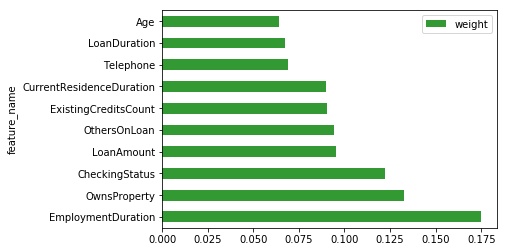

In [28]:
if explain_run == None:
    # explanation didn't finish within 180 seconds, if explaination is still not finished give it a minute or so then re-run this cell
    time.sleep(10)
    explain_table = subscription.explainability.get_table_content(format='pandas')
    explain_result = pd.DataFrame.from_dict(explain_table[explain_table['transaction_id']==transaction_id]['explanation'][0]['entity']['predictions'][0]['explanation_features'])
else:
    explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])

explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

## Congratulations!

You have finished this section of the hands-on lab for IBM Watson OpenScale. You can now view the OpenScale dashboard by going to the Cloud Pak for Data `Home` page, and clicking `Services`. Choose the `OpenScale` tile and click the menu to `Open`. Click on the tile for the model you've created to see the monitors.

OpenScale shows model performance over time. You have two options to keep data flowing to your OpenScale graphs:
  * Download, configure and schedule the [model feed notebook](https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_scoring_feed.ipynb). This notebook can be set up with your WML credentials, and scheduled to provide a consistent flow of scoring requests to your model, which will appear in your OpenScale monitors.
  * Re-run this notebook. Running this notebook from the beginning will delete and re-create the model and deployment, and re-create the historical data. Please note that the payload and measurement logs for the previous deployment will continue to be stored in your datamart, and can be deleted if necessary.


This notebook has been adapted from notebooks available at https://github.com/pmservice/ai-openscale-tutorials. 